# Braiding for Kapit-Mueller Model with First Band Approximation

In [119]:
using QuantumOptics
using NBInclude
using SparseArrays
using Arpack
using DataFrames
using Plots
using Interpolations
@nbinclude(joinpath("..","First Band Approximation Functions.ipynb"));

In [197]:
Nx = Ny = 4
N_Site = Nx*Ny
p = 1
q = 2
t = 1
Cut_Off = 8
PN = [0, 1, 2, 3]
U = 2;

In [198]:
function KM(Nx, Ny, t, p, q)
    coordinates = vcat( ( [y x] for x in 0:Nx-1 for y in 0:Ny-1 ) ... )
    alpha = p/q
    H = spzeros(Complex{Float64}, N_Site, N_Site)
    for j in 1:N_Site
        for k in 1:N_Site
            if j!=k
                x_j = coordinates[j, 1] 
                y_j = coordinates[j, 2] 
                x_k = coordinates[k, 1]
                y_k = coordinates[k, 2]
                z_j = x_j + 1im*y_j
                z_k = x_k + 1im*y_k
                for n in range(-1,1)
                    for m in range(-1,1)
                        R = n * Nx + 1im * m * Ny
                        z = (z_k - z_j) + R 
                        G = (-1) ^ ( real(z) + imag(z) + real(z) * imag(z) )
                        beta = (pi/2) * ( (z_j * conj(z) ) - (conj(z_j) * z) )*alpha
                        W = t * G * exp( -pi/2 * (1-alpha) * (abs(z)^2) )
                        J = W * exp(beta) * exp( pi/2 * ( (z_j * conj(R) ) - (conj(z_j) * R) ) * alpha)
                        H[j,k] += J
                    end
                end
            end
        end
    end
    return H
end

KM (generic function with 1 method)

In [199]:
Sp_Basis = NLevelBasis(N_Site);

In [200]:
function Sp_Sub(N_Site, Nx, Ny, t, p, q, Sp_Basis, Cut_Off)
    Sp = KM(Nx, Ny, t, p, q)
    H_Sp = get_sp_op(Sp_Basis, Sp)
    H_Sp = dense((H_Sp+H_Sp')/2)
    Sub_States = get_sub_states(H_Sp, Cut_Off)
    Sub_Basis, P, Pt = get_projector_op(Sub_States, Sp_Basis)
    H_Sp_Sub = get_subspace_op(H_Sp, P, Pt)
    return H_Sp, Sub_Basis, P, Pt, H_Sp_Sub
end

Sp_Sub (generic function with 1 method)

In [201]:
H_Sp, Sub_Basis, P, Pt, H_Sp_Sub = Sp_Sub(N_Site, Nx, Ny, t, p, q, Sp_Basis, Cut_Off);
EEA, UUA = eigenstates(H_Sp);

In [202]:
Sub_Number_Operator_List = get_num_sub_list(N_Site, Sp_Basis, P, Pt);

In [203]:
function get_MB_Sub(Sub_Basis, PN, H_Sp_Sub)
    MB_States = bosonstates(Sub_Basis, PN) 
    MB_Basis = ManyBodyBasis(Sub_Basis, MB_States)
    H_MB_Sub = get_mb_op(MB_Basis, H_Sp_Sub)
    return H_MB_Sub
end

get_MB_Sub (generic function with 1 method)

In [204]:
H_MB_Sub = get_MB_Sub(Sub_Basis, PN, H_Sp_Sub);

In [205]:
function get_Bosonic_MB_Basis(N_Site, PN)
    N_Basis = NLevelBasis(N_Site)
    N_States = bosonstates(N_Basis, PN)
    N_Basis_MB = ManyBodyBasis(N_Basis, N_States)
    return N_Basis_MB, N_Basis
end

get_Bosonic_MB_Basis (generic function with 1 method)

In [206]:
Basis_Cut_MB, Basis_Cut_Sp = get_Bosonic_MB_Basis(Cut_Off, PN)

(ManyBody(onebodybasis=NLevel(N=8), states:165), NLevel(N=8))

In [207]:
H_Kin = SparseOperator(Basis_Cut_MB)
H_Kin.data = H_MB_Sub.data;

In [208]:
H_Int = Hubbard_Interaction(P, Pt, Basis_Cut_MB, Cut_Off, U);

In [209]:
Sub_Number_MB_Operator_List = get_num_mb_op(N_Site, Basis_Cut_Sp, Sub_Number_Operator_List, Basis_Cut_MB, Sub_Basis);

In [210]:
Total_H = H_Kin + H_Int;

# Impurity

In [211]:
struct Impurity
    N_Pin::Int64
    V0::Vector{Int64}
    Imp_Site::Vector{Int64}
end

In [245]:
N_Pin = 1; V0 = [4]; Imp_Site = [11]
Impurity_Data = Impurity(N_Pin, V0, Imp_Site)

Impurity(1, [4], [11])

In [246]:
function Imp_H(Total_H, Impurity_Data)
    for imp in 1:Impurity_Data.N_Pin
        Total_H += Impurity_Data.V0[imp] * Sub_Number_MB_Operator_List[Impurity_Data.Imp_Site[imp]]
    end
    return Total_H
end

Imp_H (generic function with 1 method)

In [247]:
Impurity_H = Imp_H(Total_H, Impurity_Data)
Impurity_H = dense((Impurity_H+Impurity_H')/2);

In [248]:
E_Imp, U_Imp = eigenstates(Impurity_H)
E_Imp;

# Filter

In [249]:
pn = maximum(PN)

3

In [250]:
function Get_Filtered_Energies(Basis_Cut_MB, E_Imp, U_Imp, pn)
    Filtered_Energies = Array{Float64}(undef, length(E_Imp), 2)
    for i in 1:length(E_Imp)
        Filtered_Energies[i] = round(expect(number(Basis_Cut_MB), U_Imp[i])) 
        Filtered_Energies[i,2] = E_Imp[i] 
    end
    df = DataFrame(Filtered_Energies, :auto)
    df = filter(row -> (row.x1 == pn),  df)
    return Matrix(df)[:,2]
end

Get_Filtered_Energies (generic function with 1 method)

In [266]:
Fil_Energies = Get_Filtered_Energies(Basis_Cut_MB, E_Imp, U_Imp, pn);

In [267]:
function Get_Filtered_States(Fil_Energies, U_Imp)
    number_of_states = length(Fil_Energies)
    return U_Imp[1:number_of_states]
end

Get_Filtered_States (generic function with 1 method)

In [268]:
Fil_States = Get_Filtered_States(Fil_Energies, U_Imp);

# Density

In [269]:
function Get_Density_Profile(N_Site,Sub_Number_MB_Operator_List,Basis_Cut_MB,Fil_States,index)
    Expectation_List = []
    for site in 1:N_Site
        push!(Expectation_List, expect(Sub_Number_MB_Operator_List[site], Fil_States[index]))
    end
    return real(Expectation_List)
end

Get_Density_Profile (generic function with 2 methods)

In [273]:
function Get_Avg_Density(Nx, Ny, Degeneracy)
    Avg_Density = spzeros(Nx,Ny)
    for index in 1:Degeneracy
        Avg_Density += reshape(Get_Density_Profile(N_Site, Sub_Number_MB_Operator_List, Basis_Cut_MB, Fil_States, index), Nx, Ny)
    end    
    return Avg_Density / Degeneracy
end

Get_Avg_Density (generic function with 1 method)

In [274]:
function Interp(data, factor)
    IC = CubicSplineInterpolation((axes(data,1), axes(data,2)), data)
    finerx = LinRange(firstindex(data,1), lastindex(data,1), size(data,1) * factor)
    finery = LinRange(firstindex(data,2), lastindex(data,2), size(data,2) * factor)
    nx = length(finerx)
    ny = length(finery)
    data_interp = Array{Float64}(undef,nx,ny)
    for i ∈ 1:nx, j ∈ 1:ny
        data_interp[i,j] = IC(finerx[i],finery[j])
    end
    return finery, finerx, data_interp
end

Interp (generic function with 1 method)

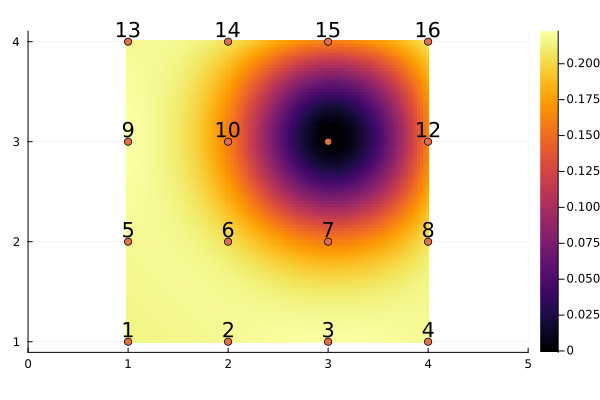

In [275]:
Degeneracy = 7
data = Get_Avg_Density(Nx, Ny, Degeneracy)
factor = 25
Plots.heatmap(Interp(data, factor), aspect_ratio=:equal)
co = vcat( ( [y x] for x in 0:Nx-1 for y in 0:Ny-1 ) ... )
scatter!(co[:,1].+1,co[:,2].+1, series_annotations = text.([i for i in 1:N_Site], :bottom), legend=false)

In [276]:
sum(Get_Avg_Density(Nx, Ny, Degeneracy))

3.0

# Moving A Quasihole

In [299]:
function closed_path(start_point,len)
    path = []
    for i in 1:len
        push!(path,i+start_point)
    end
    for i in 1:len
        push!(path,last(path)-Ny)
    end
    for i in 1:len
        push!(path,last(path)-1)
    end
    for i in 1:len
        push!(path,last(path)+Ny)
    end
    return path
end

closed_path (generic function with 1 method)

In [302]:
closed_path(13,3)

12-element Vector{Any}:
 14
 15
 16
 12
  8
  4
  3
  2
  1
  5
  9
 13